In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                     | 0/50000 [00:00<?, ?it/s]

  9%|███████▌                                                                               | 4355/50000 [00:00<00:01, 43541.84it/s]

 17%|███████████████▏                                                                       | 8744/50000 [00:00<00:00, 43743.70it/s]

 26%|██████████████████████▋                                                               | 13160/50000 [00:00<00:00, 43929.30it/s]

 35%|██████████████████████████████▏                                                       | 17586/50000 [00:00<00:00, 44055.51it/s]

 44%|█████████████████████████████████████▊                                                | 21992/50000 [00:00<00:00, 44046.05it/s]

 53%|█████████████████████████████████████████████▍                                        | 26428/50000 [00:00<00:00, 44152.31it/s]

 62%|█████████████████████████████████████████████████████                                 | 30875/50000 [00:00<00:00, 44252.86it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 35301/50000 [00:00<00:00, 44229.84it/s]

 79%|████████████████████████████████████████████████████████████████████▎                 | 39724/50000 [00:00<00:00, 44180.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 44145/50000 [00:01<00:00, 44186.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 48564/50000 [00:01<00:00, 44184.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44101.82it/s]

Files already downloaded and verified


  0%|                                                                                                     | 0/10000 [00:00<?, ?it/s]

 44%|█████████████████████████████████████▉                                                 | 4367/10000 [00:00<00:00, 43657.66it/s]

 87%|███████████████████████████████████████████████████████████████████████████▉           | 8735/10000 [00:00<00:00, 43668.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43604.14it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 ks6467y3


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ks6467y3:best, 58.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                       | 0/313 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/313 [00:00<02:59,  1.74it/s]

  1%|▉                                                                                              | 3/313 [00:00<01:03,  4.88it/s]

  2%|█▌                                                                                             | 5/313 [00:00<00:41,  7.51it/s]

  2%|██                                                                                             | 7/313 [00:00<00:31,  9.59it/s]

  3%|██▋                                                                                            | 9/313 [00:01<00:27, 11.18it/s]

  4%|███▎                                                                                          | 11/313 [00:01<00:24, 12.35it/s]

  4%|███▉                                                                                          | 13/313 [00:01<00:22, 13.22it/s]

  5%|████▌                                                                                         | 15/313 [00:01<00:21, 13.84it/s]

  5%|█████                                                                                         | 17/313 [00:01<00:20, 14.28it/s]

  6%|█████▋                                                                                        | 19/313 [00:01<00:20, 14.60it/s]

  7%|██████▎                                                                                       | 21/313 [00:01<00:19, 14.83it/s]

  7%|██████▉                                                                                       | 23/313 [00:02<00:19, 14.99it/s]

  8%|███████▌                                                                                      | 25/313 [00:02<00:19, 15.10it/s]

  9%|████████                                                                                      | 27/313 [00:02<00:18, 15.18it/s]

  9%|████████▋                                                                                     | 29/313 [00:02<00:18, 15.22it/s]

 10%|█████████▎                                                                                    | 31/313 [00:02<00:18, 15.25it/s]

 11%|█████████▉                                                                                    | 33/313 [00:02<00:18, 15.26it/s]

 11%|██████████▌                                                                                   | 35/313 [00:02<00:18, 15.28it/s]

 12%|███████████                                                                                   | 37/313 [00:02<00:18, 15.30it/s]

 12%|███████████▋                                                                                  | 39/313 [00:03<00:17, 15.31it/s]

 13%|████████████▎                                                                                 | 41/313 [00:03<00:17, 15.31it/s]

 14%|████████████▉                                                                                 | 43/313 [00:03<00:17, 15.30it/s]

 14%|█████████████▌                                                                                | 45/313 [00:03<00:17, 15.29it/s]

 15%|██████████████                                                                                | 47/313 [00:03<00:17, 15.29it/s]

 16%|██████████████▋                                                                               | 49/313 [00:03<00:17, 15.29it/s]

 16%|███████████████▎                                                                              | 51/313 [00:03<00:17, 15.29it/s]

 17%|███████████████▉                                                                              | 53/313 [00:03<00:16, 15.30it/s]

 18%|████████████████▌                                                                             | 55/313 [00:04<00:16, 15.31it/s]

 18%|█████████████████                                                                             | 57/313 [00:04<00:16, 15.31it/s]

 19%|█████████████████▋                                                                            | 59/313 [00:04<00:16, 15.30it/s]

 19%|██████████████████▎                                                                           | 61/313 [00:04<00:16, 15.30it/s]

 20%|██████████████████▉                                                                           | 63/313 [00:04<00:16, 15.30it/s]

 21%|███████████████████▌                                                                          | 65/313 [00:04<00:16, 15.29it/s]

 21%|████████████████████                                                                          | 67/313 [00:04<00:16, 15.29it/s]

 22%|████████████████████▋                                                                         | 69/313 [00:05<00:15, 15.30it/s]

 23%|█████████████████████▎                                                                        | 71/313 [00:05<00:15, 15.30it/s]

 23%|█████████████████████▉                                                                        | 73/313 [00:05<00:15, 15.30it/s]

 24%|██████████████████████▌                                                                       | 75/313 [00:05<00:15, 15.31it/s]

 25%|███████████████████████                                                                       | 77/313 [00:05<00:15, 15.30it/s]

 25%|███████████████████████▋                                                                      | 79/313 [00:05<00:15, 15.30it/s]

 26%|████████████████████████▎                                                                     | 81/313 [00:05<00:15, 15.30it/s]

 27%|████████████████████████▉                                                                     | 83/313 [00:05<00:15, 15.29it/s]

 27%|█████████████████████████▌                                                                    | 85/313 [00:06<00:14, 15.29it/s]

 28%|██████████████████████████▏                                                                   | 87/313 [00:06<00:14, 15.30it/s]

 28%|██████████████████████████▋                                                                   | 89/313 [00:06<00:14, 15.31it/s]

 29%|███████████████████████████▎                                                                  | 91/313 [00:06<00:14, 15.31it/s]

 30%|███████████████████████████▉                                                                  | 93/313 [00:06<00:14, 15.31it/s]

 30%|████████████████████████████▌                                                                 | 95/313 [00:06<00:14, 15.29it/s]

 31%|█████████████████████████████▏                                                                | 97/313 [00:06<00:14, 15.29it/s]

 32%|█████████████████████████████▋                                                                | 99/313 [00:06<00:14, 15.28it/s]

 32%|██████████████████████████████                                                               | 101/313 [00:07<00:13, 15.28it/s]

 33%|██████████████████████████████▌                                                              | 103/313 [00:07<00:13, 15.29it/s]

 34%|███████████████████████████████▏                                                             | 105/313 [00:07<00:13, 15.30it/s]

 34%|███████████████████████████████▊                                                             | 107/313 [00:07<00:13, 15.30it/s]

 35%|████████████████████████████████▍                                                            | 109/313 [00:07<00:13, 15.31it/s]

 35%|████████████████████████████████▉                                                            | 111/313 [00:07<00:13, 15.30it/s]

 36%|█████████████████████████████████▌                                                           | 113/313 [00:07<00:13, 15.30it/s]

 37%|██████████████████████████████████▏                                                          | 115/313 [00:08<00:12, 15.30it/s]

 37%|██████████████████████████████████▊                                                          | 117/313 [00:08<00:12, 15.30it/s]

 38%|███████████████████████████████████▎                                                         | 119/313 [00:08<00:12, 15.30it/s]

 39%|███████████████████████████████████▉                                                         | 121/313 [00:08<00:12, 15.29it/s]

 39%|████████████████████████████████████▌                                                        | 123/313 [00:08<00:12, 15.30it/s]

 40%|█████████████████████████████████████▏                                                       | 125/313 [00:08<00:12, 15.31it/s]

 41%|█████████████████████████████████████▋                                                       | 127/313 [00:08<00:12, 15.32it/s]

 41%|██████████████████████████████████████▎                                                      | 129/313 [00:08<00:12, 15.31it/s]

 42%|██████████████████████████████████████▉                                                      | 131/313 [00:09<00:11, 15.31it/s]

 42%|███████████████████████████████████████▌                                                     | 133/313 [00:09<00:11, 15.30it/s]

 43%|████████████████████████████████████████                                                     | 135/313 [00:09<00:11, 15.30it/s]

 44%|████████████████████████████████████████▋                                                    | 137/313 [00:09<00:11, 15.29it/s]

 44%|█████████████████████████████████████████▎                                                   | 139/313 [00:09<00:11, 15.29it/s]

 45%|█████████████████████████████████████████▉                                                   | 141/313 [00:09<00:11, 15.30it/s]

 46%|██████████████████████████████████████████▍                                                  | 143/313 [00:09<00:11, 15.32it/s]

 46%|███████████████████████████████████████████                                                  | 145/313 [00:09<00:10, 15.32it/s]

 47%|███████████████████████████████████████████▋                                                 | 147/313 [00:10<00:10, 15.32it/s]

 48%|████████████████████████████████████████████▎                                                | 149/313 [00:10<00:10, 15.31it/s]

 48%|████████████████████████████████████████████▊                                                | 151/313 [00:10<00:10, 15.31it/s]

 49%|█████████████████████████████████████████████▍                                               | 153/313 [00:10<00:10, 15.30it/s]

 50%|██████████████████████████████████████████████                                               | 155/313 [00:10<00:10, 15.29it/s]

 50%|██████████████████████████████████████████████▋                                              | 157/313 [00:10<00:10, 15.29it/s]

 51%|███████████████████████████████████████████████▏                                             | 159/313 [00:10<00:10, 15.31it/s]

 51%|███████████████████████████████████████████████▊                                             | 161/313 [00:11<00:09, 15.32it/s]

 52%|████████████████████████████████████████████████▍                                            | 163/313 [00:11<00:09, 15.32it/s]

 53%|█████████████████████████████████████████████████                                            | 165/313 [00:11<00:09, 15.31it/s]

 53%|█████████████████████████████████████████████████▌                                           | 167/313 [00:11<00:09, 15.31it/s]

 54%|██████████████████████████████████████████████████▏                                          | 169/313 [00:11<00:09, 15.31it/s]

 55%|██████████████████████████████████████████████████▊                                          | 171/313 [00:11<00:09, 15.30it/s]

 55%|███████████████████████████████████████████████████▍                                         | 173/313 [00:11<00:09, 15.30it/s]

 56%|███████████████████████████████████████████████████▉                                         | 175/313 [00:11<00:09, 15.30it/s]

 57%|████████████████████████████████████████████████████▌                                        | 177/313 [00:12<00:08, 15.31it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 179/313 [00:12<00:08, 15.28it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 181/313 [00:12<00:08, 15.29it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 183/313 [00:12<00:08, 15.29it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 185/313 [00:12<00:08, 15.29it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 187/313 [00:12<00:08, 15.30it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 189/313 [00:12<00:08, 15.30it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 191/313 [00:13<00:07, 15.30it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 193/313 [00:13<00:07, 15.30it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 195/313 [00:13<00:07, 15.31it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 197/313 [00:13<00:07, 15.30it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 199/313 [00:13<00:07, 15.30it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 201/313 [00:13<00:07, 15.30it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 203/313 [00:13<00:07, 15.29it/s]

 65%|████████████████████████████████████████████████████████████▉                                | 205/313 [00:13<00:07, 15.29it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 207/313 [00:14<00:06, 15.29it/s]

 67%|██████████████████████████████████████████████████████████████                               | 209/313 [00:14<00:06, 15.29it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 211/313 [00:14<00:06, 15.30it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 213/313 [00:14<00:06, 15.31it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 215/313 [00:14<00:06, 15.32it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 217/313 [00:14<00:06, 15.31it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 219/313 [00:14<00:06, 15.31it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 221/313 [00:14<00:06, 15.28it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 223/313 [00:15<00:05, 15.29it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 225/313 [00:15<00:05, 15.29it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 227/313 [00:15<00:05, 15.30it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 229/313 [00:15<00:05, 15.31it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 231/313 [00:15<00:05, 15.32it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 233/313 [00:15<00:05, 15.32it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 235/313 [00:15<00:05, 15.32it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 237/313 [00:16<00:04, 15.31it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 239/313 [00:16<00:04, 15.31it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 241/313 [00:16<00:04, 15.31it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 243/313 [00:16<00:04, 15.31it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 245/313 [00:16<00:04, 15.32it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 247/313 [00:16<00:04, 15.33it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 249/313 [00:16<00:04, 15.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 251/313 [00:16<00:04, 15.32it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 253/313 [00:17<00:03, 15.31it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 255/313 [00:17<00:03, 15.31it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 257/313 [00:17<00:03, 15.31it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 259/313 [00:17<00:03, 15.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 261/313 [00:17<00:03, 15.31it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 263/313 [00:17<00:03, 15.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 265/313 [00:17<00:03, 15.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 267/313 [00:17<00:02, 15.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 269/313 [00:18<00:02, 15.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 271/313 [00:18<00:02, 15.32it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 273/313 [00:18<00:02, 15.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 275/313 [00:18<00:02, 15.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 277/313 [00:18<00:02, 15.32it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 279/313 [00:18<00:02, 15.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 281/313 [00:18<00:02, 15.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 283/313 [00:19<00:01, 15.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 285/313 [00:19<00:01, 15.34it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 287/313 [00:19<00:01, 15.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 289/313 [00:19<00:01, 15.33it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 291/313 [00:19<00:01, 15.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 293/313 [00:19<00:01, 15.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 295/313 [00:19<00:01, 15.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 297/313 [00:19<00:01, 15.32it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊    | 299/313 [00:20<00:00, 15.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 301/313 [00:20<00:00, 15.34it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 303/313 [00:20<00:00, 15.34it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 305/313 [00:20<00:00, 15.29it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 307/313 [00:20<00:00, 15.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 309/313 [00:20<00:00, 15.31it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 311/313 [00:20<00:00, 15.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 14.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.90it/s]

train - OK


  0%|                                                                                                        | 0/79 [00:00<?, ?it/s]

  1%|█▏                                                                                              | 1/79 [00:00<00:15,  5.02it/s]

  4%|███▋                                                                                            | 3/79 [00:00<00:07,  9.99it/s]

  6%|██████                                                                                          | 5/79 [00:00<00:06, 12.17it/s]

  9%|████████▌                                                                                       | 7/79 [00:00<00:05, 13.33it/s]

 11%|██████████▉                                                                                     | 9/79 [00:00<00:05, 13.99it/s]

 14%|█████████████▏                                                                                 | 11/79 [00:00<00:04, 14.42it/s]

 16%|███████████████▋                                                                               | 13/79 [00:00<00:04, 14.70it/s]

 19%|██████████████████                                                                             | 15/79 [00:01<00:04, 14.89it/s]

 22%|████████████████████▍                                                                          | 17/79 [00:01<00:04, 15.02it/s]

 24%|██████████████████████▊                                                                        | 19/79 [00:01<00:03, 15.12it/s]

 27%|█████████████████████████▎                                                                     | 21/79 [00:01<00:03, 15.19it/s]

 29%|███████████████████████████▋                                                                   | 23/79 [00:01<00:03, 15.24it/s]

 32%|██████████████████████████████                                                                 | 25/79 [00:01<00:03, 15.26it/s]

 34%|████████████████████████████████▍                                                              | 27/79 [00:01<00:03, 15.28it/s]

 37%|██████████████████████████████████▊                                                            | 29/79 [00:02<00:03, 15.29it/s]

 39%|█████████████████████████████████████▎                                                         | 31/79 [00:02<00:03, 15.29it/s]

 42%|███████████████████████████████████████▋                                                       | 33/79 [00:02<00:03, 15.30it/s]

 44%|██████████████████████████████████████████                                                     | 35/79 [00:02<00:02, 15.31it/s]

 47%|████████████████████████████████████████████▍                                                  | 37/79 [00:02<00:02, 15.33it/s]

 49%|██████████████████████████████████████████████▉                                                | 39/79 [00:02<00:02, 15.33it/s]

 52%|█████████████████████████████████████████████████▎                                             | 41/79 [00:02<00:02, 15.33it/s]

 54%|███████████████████████████████████████████████████▋                                           | 43/79 [00:02<00:02, 15.31it/s]

 57%|██████████████████████████████████████████████████████                                         | 45/79 [00:03<00:02, 15.31it/s]

 59%|████████████████████████████████████████████████████████▌                                      | 47/79 [00:03<00:02, 15.31it/s]

 62%|██████████████████████████████████████████████████████████▉                                    | 49/79 [00:03<00:01, 15.31it/s]

 65%|█████████████████████████████████████████████████████████████▎                                 | 51/79 [00:03<00:01, 15.32it/s]

 67%|███████████████████████████████████████████████████████████████▋                               | 53/79 [00:03<00:01, 15.33it/s]

 70%|██████████████████████████████████████████████████████████████████▏                            | 55/79 [00:03<00:01, 15.34it/s]

 72%|████████████████████████████████████████████████████████████████████▌                          | 57/79 [00:03<00:01, 15.34it/s]

 75%|██████████████████████████████████████████████████████████████████████▉                        | 59/79 [00:03<00:01, 15.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████▎                     | 61/79 [00:04<00:01, 15.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████▊                   | 63/79 [00:04<00:01, 15.32it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▏                | 65/79 [00:04<00:00, 15.31it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▌              | 67/79 [00:04<00:00, 15.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 69/79 [00:04<00:00, 15.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 71/79 [00:04<00:00, 15.33it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 73/79 [00:04<00:00, 15.32it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 75/79 [00:05<00:00, 15.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 77/79 [00:05<00:00, 15.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.77it/s]

val - OK


  0%|                                                                                                        | 0/79 [00:00<?, ?it/s]

  1%|█▏                                                                                              | 1/79 [00:00<00:17,  4.40it/s]

  4%|███▋                                                                                            | 3/79 [00:00<00:08,  9.30it/s]

  6%|██████                                                                                          | 5/79 [00:00<00:06, 11.67it/s]

  9%|████████▌                                                                                       | 7/79 [00:00<00:05, 12.99it/s]

 11%|██████████▉                                                                                     | 9/79 [00:00<00:05, 13.80it/s]

 14%|█████████████▏                                                                                 | 11/79 [00:00<00:04, 14.31it/s]

 16%|███████████████▋                                                                               | 13/79 [00:01<00:04, 14.63it/s]

 19%|██████████████████                                                                             | 15/79 [00:01<00:04, 14.85it/s]

 22%|████████████████████▍                                                                          | 17/79 [00:01<00:04, 15.00it/s]

 24%|██████████████████████▊                                                                        | 19/79 [00:01<00:03, 15.10it/s]

 27%|█████████████████████████▎                                                                     | 21/79 [00:01<00:03, 15.17it/s]

 29%|███████████████████████████▋                                                                   | 23/79 [00:01<00:03, 15.23it/s]

 32%|██████████████████████████████                                                                 | 25/79 [00:01<00:03, 15.28it/s]

 34%|████████████████████████████████▍                                                              | 27/79 [00:01<00:03, 15.31it/s]

 37%|██████████████████████████████████▊                                                            | 29/79 [00:02<00:03, 15.32it/s]

 39%|█████████████████████████████████████▎                                                         | 31/79 [00:02<00:03, 15.32it/s]

 42%|███████████████████████████████████████▋                                                       | 33/79 [00:02<00:03, 15.32it/s]

 44%|██████████████████████████████████████████                                                     | 35/79 [00:02<00:02, 15.33it/s]

 47%|████████████████████████████████████████████▍                                                  | 37/79 [00:02<00:02, 15.33it/s]

 49%|██████████████████████████████████████████████▉                                                | 39/79 [00:02<00:02, 15.33it/s]

 52%|█████████████████████████████████████████████████▎                                             | 41/79 [00:02<00:02, 15.34it/s]

 54%|███████████████████████████████████████████████████▋                                           | 43/79 [00:02<00:02, 15.35it/s]

 57%|██████████████████████████████████████████████████████                                         | 45/79 [00:03<00:02, 15.36it/s]

 59%|████████████████████████████████████████████████████████▌                                      | 47/79 [00:03<00:02, 15.35it/s]

 62%|██████████████████████████████████████████████████████████▉                                    | 49/79 [00:03<00:01, 15.34it/s]

 65%|█████████████████████████████████████████████████████████████▎                                 | 51/79 [00:03<00:01, 15.34it/s]

 67%|███████████████████████████████████████████████████████████████▋                               | 53/79 [00:03<00:01, 15.34it/s]

 70%|██████████████████████████████████████████████████████████████████▏                            | 55/79 [00:03<00:01, 15.25it/s]

 72%|████████████████████████████████████████████████████████████████████▌                          | 57/79 [00:03<00:01, 15.27it/s]

 75%|██████████████████████████████████████████████████████████████████████▉                        | 59/79 [00:04<00:01, 15.30it/s]

 77%|█████████████████████████████████████████████████████████████████████████▎                     | 61/79 [00:04<00:01, 15.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████▊                   | 63/79 [00:04<00:01, 15.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▏                | 65/79 [00:04<00:00, 15.33it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▌              | 67/79 [00:04<00:00, 15.34it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 69/79 [00:04<00:00, 15.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 71/79 [00:04<00:00, 15.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 73/79 [00:04<00:00, 15.33it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 75/79 [00:05<00:00, 15.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 77/79 [00:05<00:00, 15.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.80it/s]

test InD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:06, 15.32it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:06, 15.33it/s]

  6%|█████▋                                                                                         | 6/100 [00:00<00:06, 15.34it/s]

  8%|███████▌                                                                                       | 8/100 [00:00<00:05, 15.34it/s]

 10%|█████████▍                                                                                    | 10/100 [00:00<00:05, 15.35it/s]

 12%|███████████▎                                                                                  | 12/100 [00:00<00:05, 15.36it/s]

 14%|█████████████▏                                                                                | 14/100 [00:00<00:05, 15.37it/s]

 16%|███████████████                                                                               | 16/100 [00:01<00:05, 15.37it/s]

 18%|████████████████▉                                                                             | 18/100 [00:01<00:05, 15.36it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:01<00:05, 15.36it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:01<00:05, 15.36it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:01<00:04, 15.36it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:01<00:04, 15.36it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:01<00:04, 15.36it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:01<00:04, 15.37it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:02<00:04, 15.37it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:02<00:04, 15.37it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:02<00:04, 15.37it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:02<00:04, 15.37it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:02<00:03, 15.36it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:02<00:03, 15.36it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:02<00:03, 15.36it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:02<00:03, 15.36it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:03<00:03, 15.37it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:03<00:03, 15.37it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:03<00:03, 15.37it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:03<00:02, 15.37it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:03<00:02, 15.36it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:03<00:02, 15.36it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:03<00:02, 15.36it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:04<00:02, 15.36it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:04<00:02, 15.36it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:04<00:02, 15.37it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:04<00:02, 15.38it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:04<00:01, 15.37it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:04<00:01, 15.37it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:04<00:01, 15.36it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:04<00:01, 15.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:05<00:01, 15.36it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:05<00:01, 15.36it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:05<00:01, 15.35it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:05<00:01, 15.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:05<00:00, 15.36it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:05<00:00, 15.36it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:05<00:00, 15.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:05<00:00, 15.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:06<00:00, 15.35it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:06<00:00, 15.35it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:06<00:00, 15.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.36it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 3, 32, 32) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(12800, 3, 32, 32) (12800, 3, 32, 32) (12800, 512) (12800, 10)


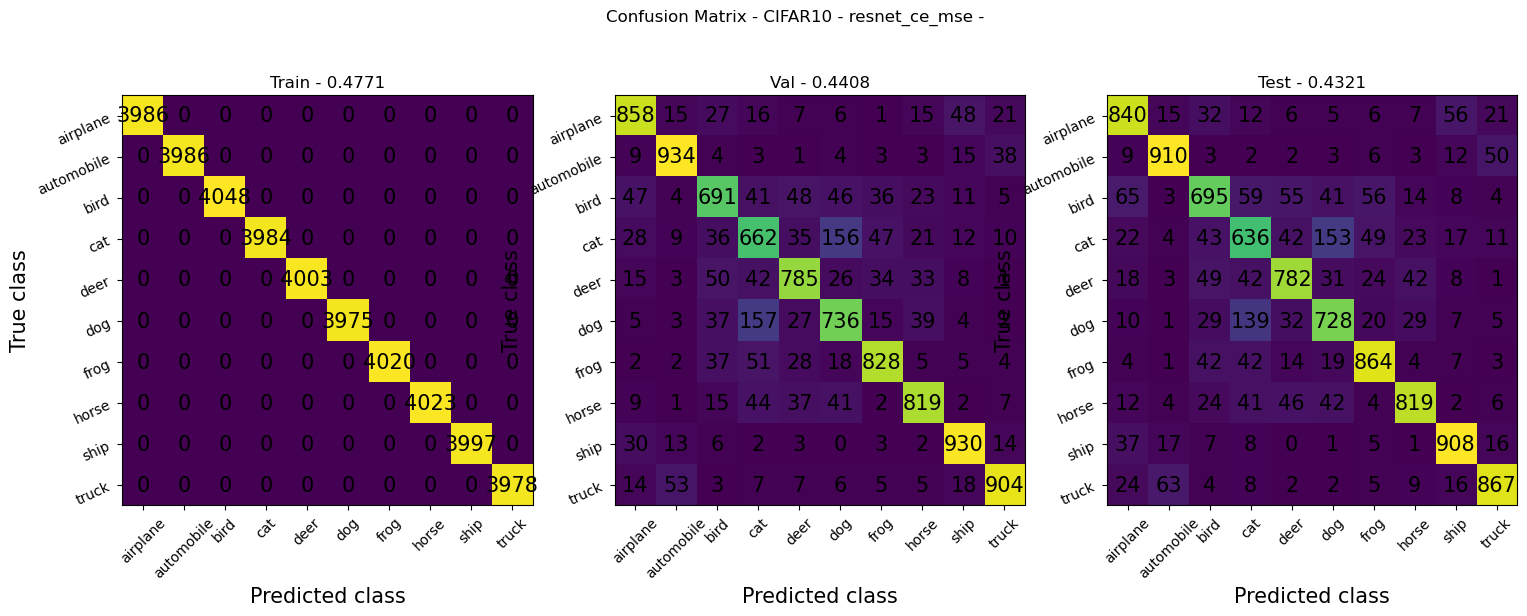

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


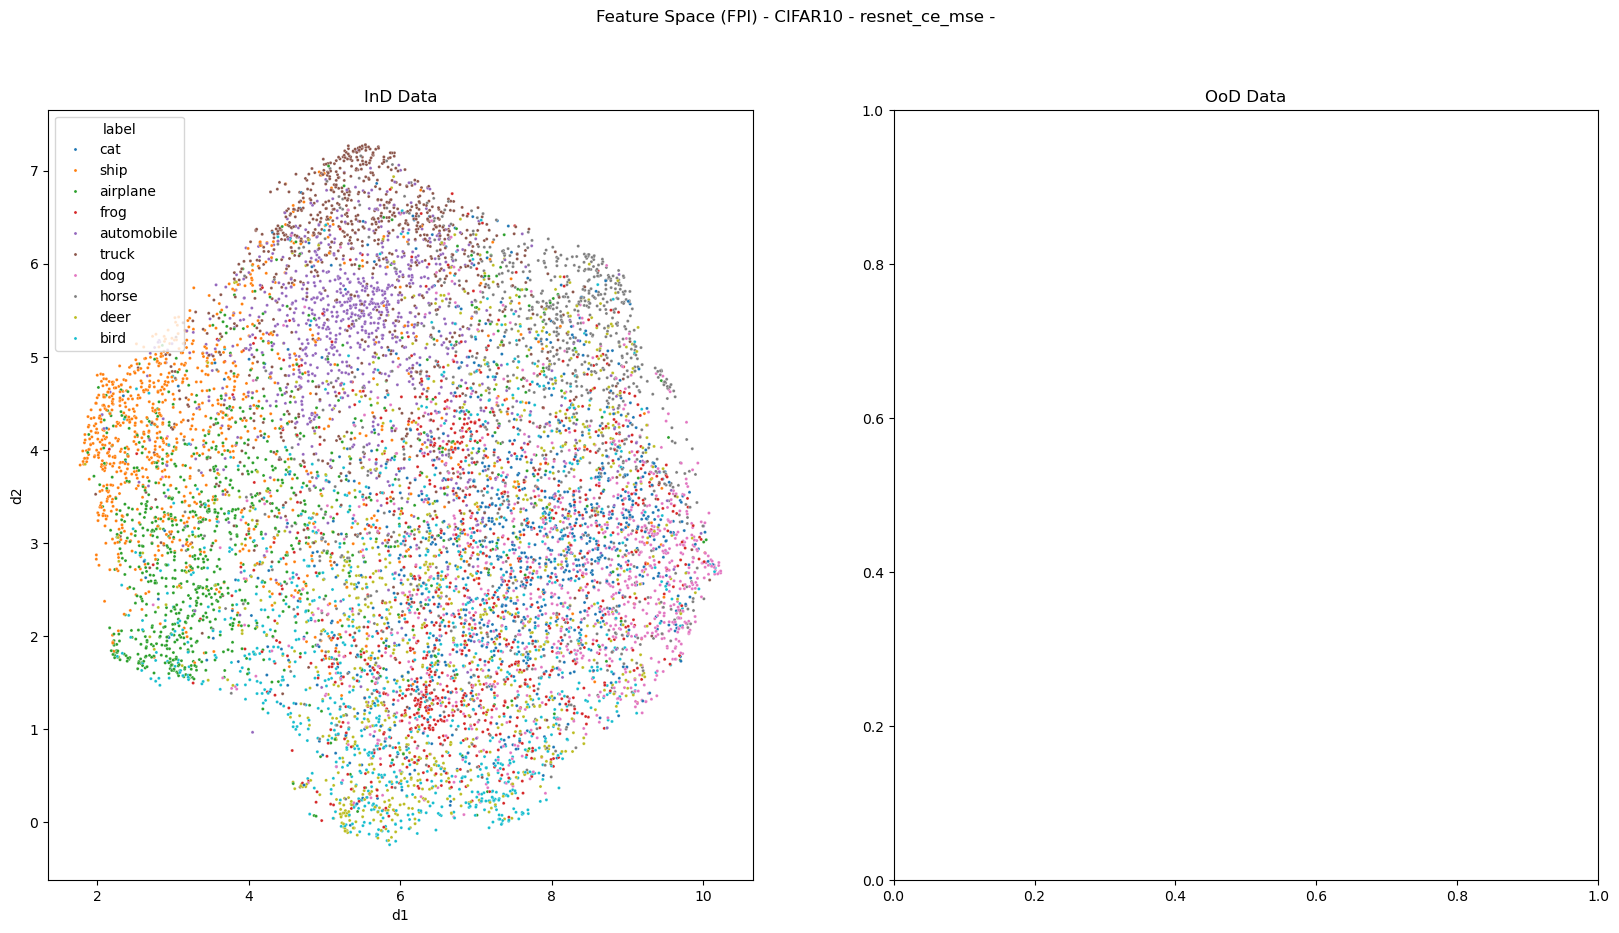

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

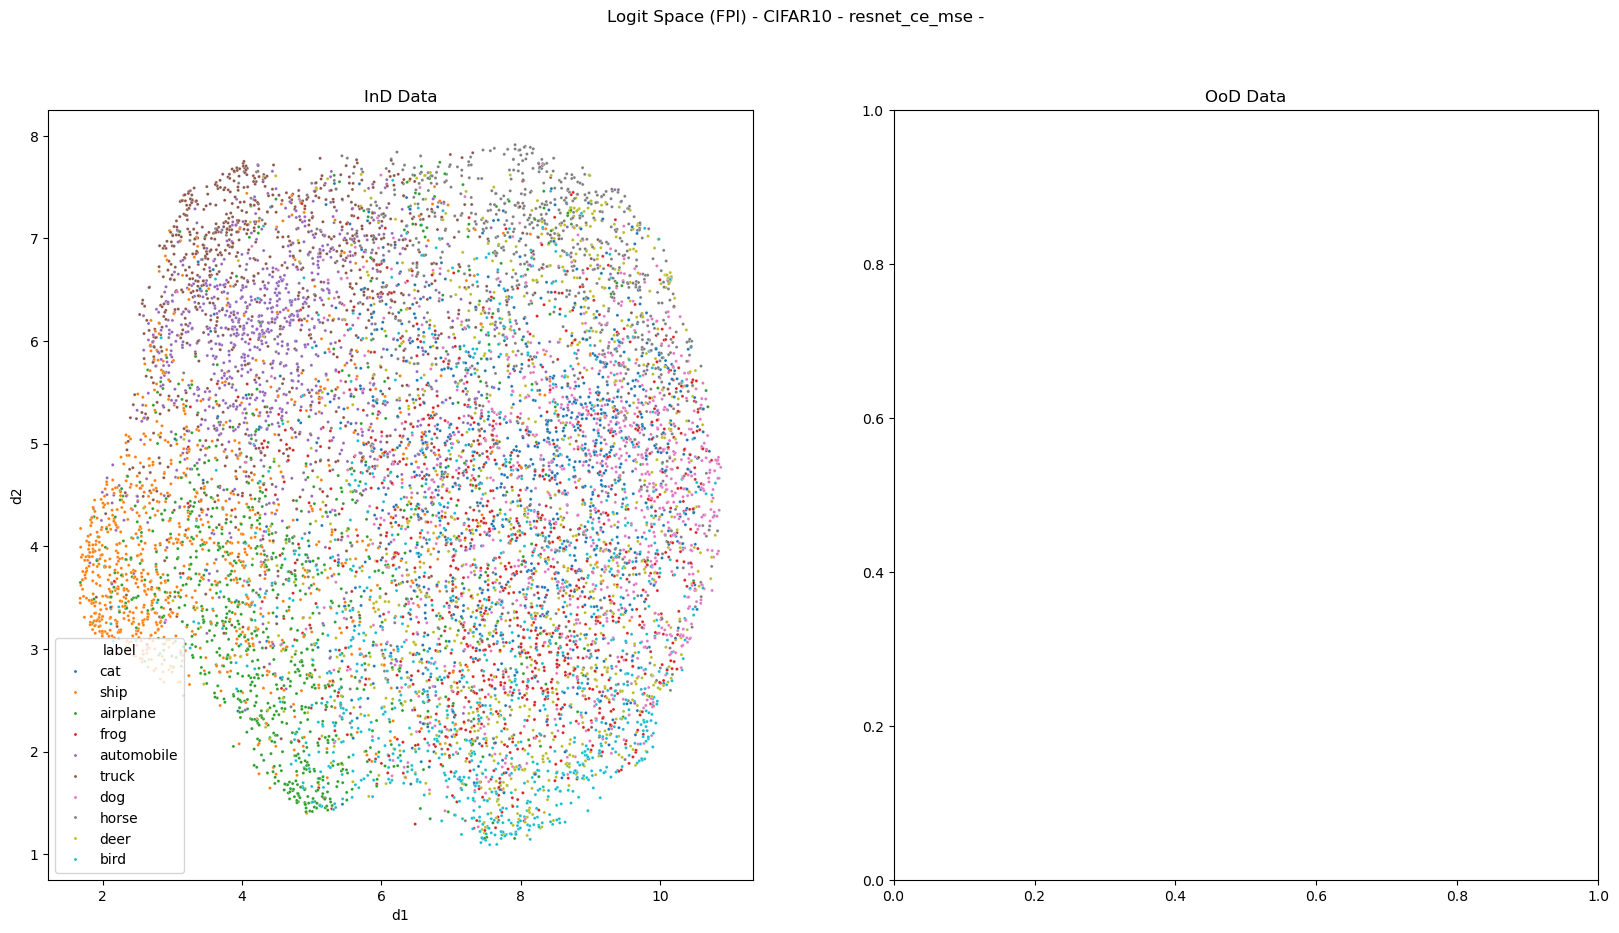

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

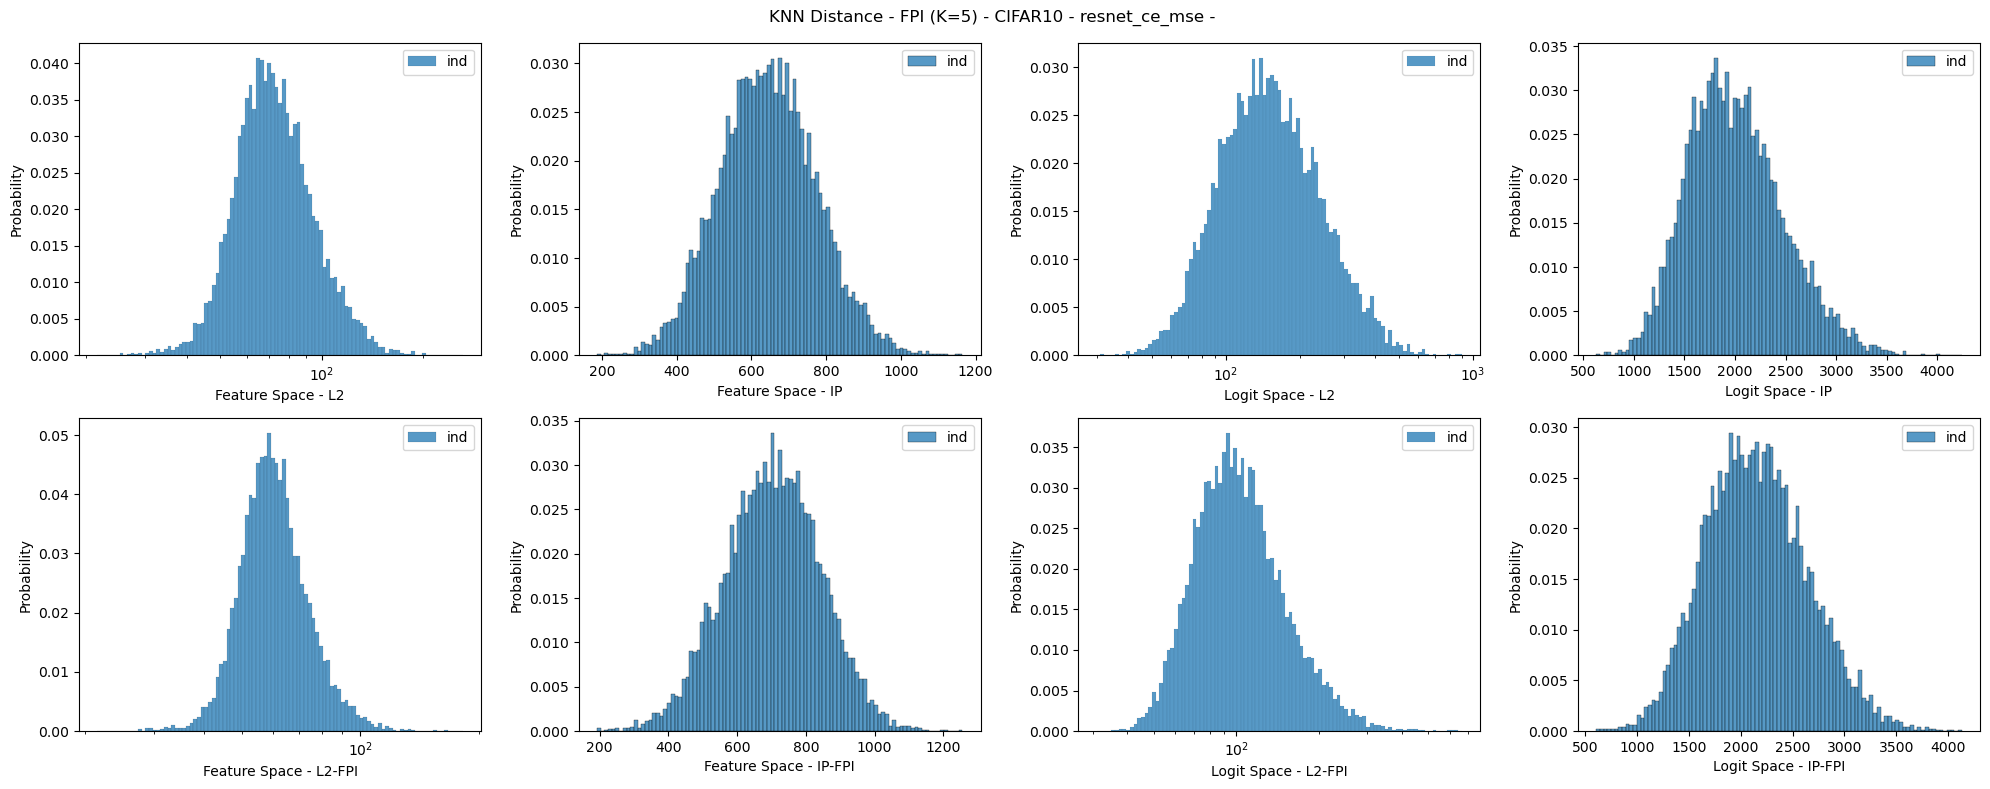

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

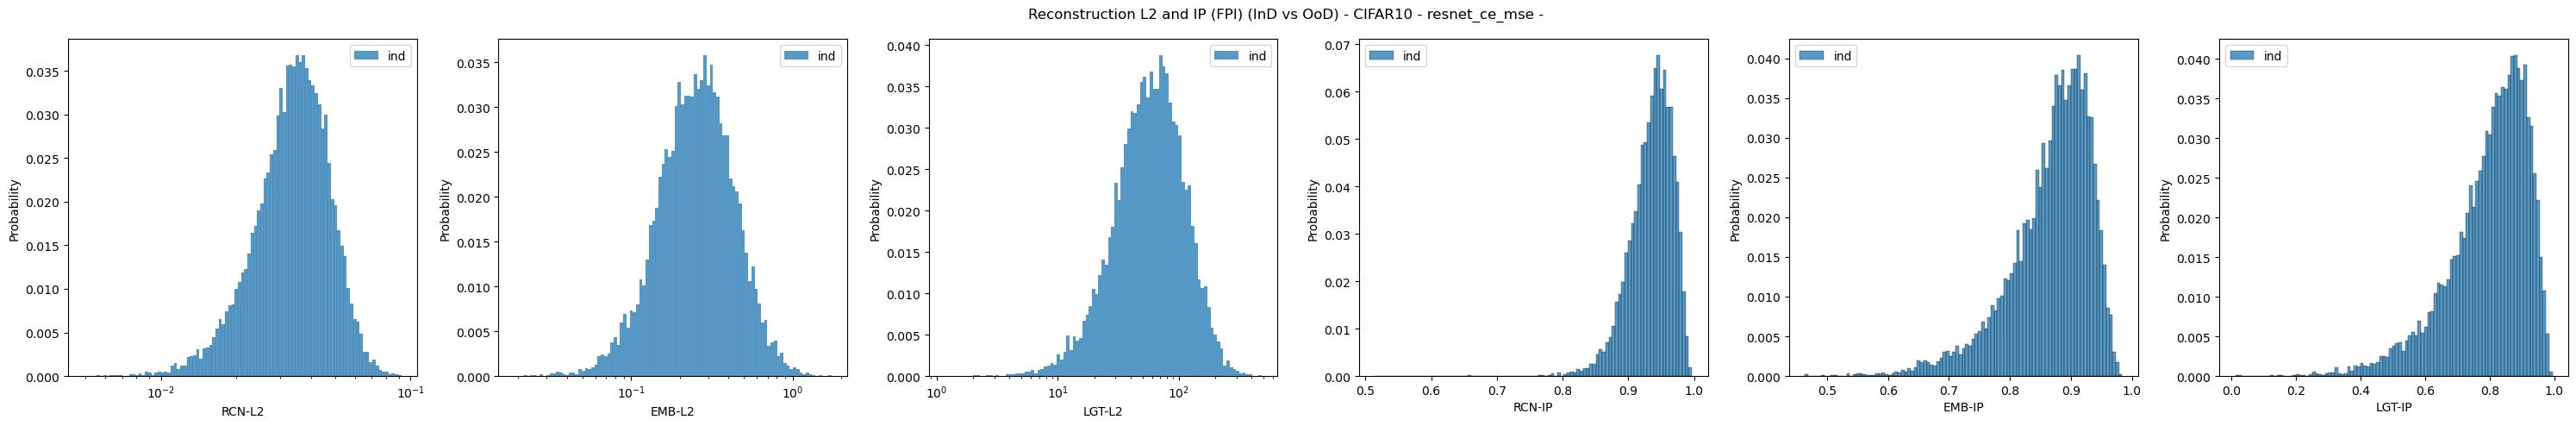

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

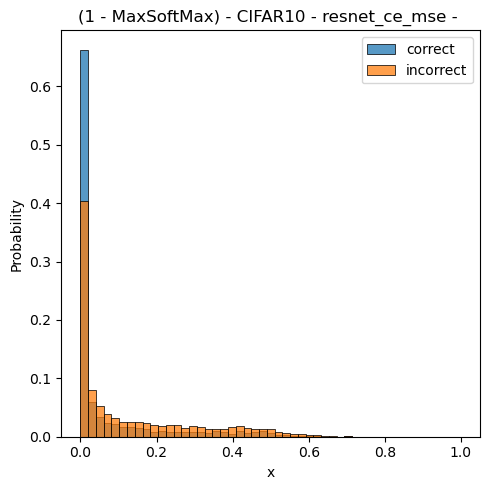

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()